In [3]:
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.arima.model as smta
import matplotlib.pyplot as plt
# %matplotlib inline
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

In [4]:
# Проверка стационарности временного ряда
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
# Визуализация временного ряда
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [6]:
# Функция для поиска лучшей модели ARIMA
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    # Указываем тренд при создании модели
                    tmp_mdl = smta.ARIMA(TS, order=(i, d, j)).fit()
                    tmp_aic = tmp_mdl.aic

                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except Exception as e:
                    #print(f'Error for order {(i, d, j)}: {e}')
                    continue
    print('Best model: aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

In [7]:
# Функция для построения графиков остатков модели
def tsplot1(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, (pd.Series, np.ndarray)):
        y = np.array(y)

    plt.style.use(style)
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts_ax.plot(y)
    ts_ax.set_title('Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 8))
    qq_ax = fig.add_subplot(111)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Q-Q plot')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.hist(y, bins=30, edgecolor='k')
    plt.title('Histogram of residuals')
    plt.show()

## Проведем анализ для daily-total-female-births-in-cal

Results of Dickey-Fuller Test:
Test Statistic                  -4.353173
p-value                          0.000359
#Lags Used                       7.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64


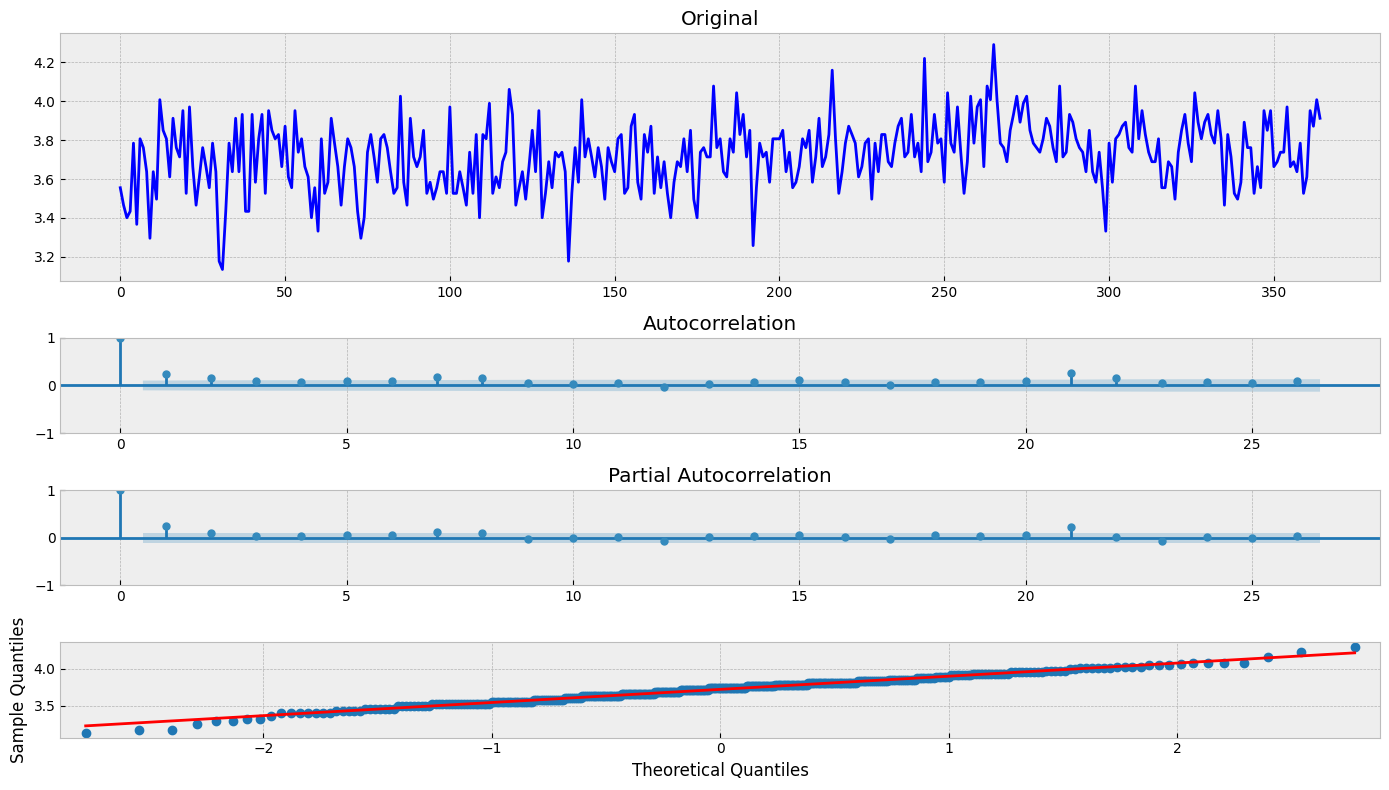

In [9]:
# Загрузка и преобразование данных
new_series = pd.read_csv("daily-total-female-births-in-cal.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
#new_series = new_series[1:] - new_series[:-1] график уже стационарный по тестам, не вижу смысла использовать какие-то преобразования

# Визуализация новой временной серии
tsplot(new_series)

На концах графика квантилей можно увидеть что значения отходят от прямой. Можно предположить, что на данном графике дисперсия ведёт себя как авторегрессия и построить GARCH.

In [10]:
new_series

array([3.55534806, 3.4657359 , 3.40119738, 3.4339872 , 3.78418963,
       3.36729583, 3.80666249, 3.76120012, 3.63758616, 3.29583687,
       3.63758616, 3.49650756, 4.00733319, 3.8501476 , 3.80666249,
       3.61091791, 3.91202301, 3.76120012, 3.71357207, 3.95124372,
       3.52636052, 3.97029191, 3.66356165, 3.4657359 , 3.61091791,
       3.76120012, 3.66356165, 3.55534806, 3.78418963, 3.63758616,
       3.17805383, 3.13549422, 3.4339872 , 3.78418963, 3.63758616,
       3.91202301, 3.63758616, 3.93182563, 3.4339872 , 3.4339872 ,
       3.93182563, 3.58351894, 3.80666249, 3.93182563, 3.52636052,
       3.95124372, 3.8501476 , 3.80666249, 3.8286414 , 3.66356165,
       3.87120101, 3.61091791, 3.55534806, 3.95124372, 3.73766962,
       3.80666249, 3.66356165, 3.61091791, 3.40119738, 3.55534806,
       3.33220451, 3.80666249, 3.52636052, 3.58351894, 3.91202301,
       3.78418963, 3.66356165, 3.4657359 , 3.66356165, 3.80666249,
       3.76120012, 3.66356165, 3.4339872 , 3.29583687, 3.40119

In [11]:
# Поиск лучшей модели ARIMA для новой временной серии
aic, order, mdl = _get_best_model(new_series)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

Best model: aic: -261.64742 | order: (1, 1, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results of Dickey-Fuller Test:
Test Statistic                 -29.023580
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


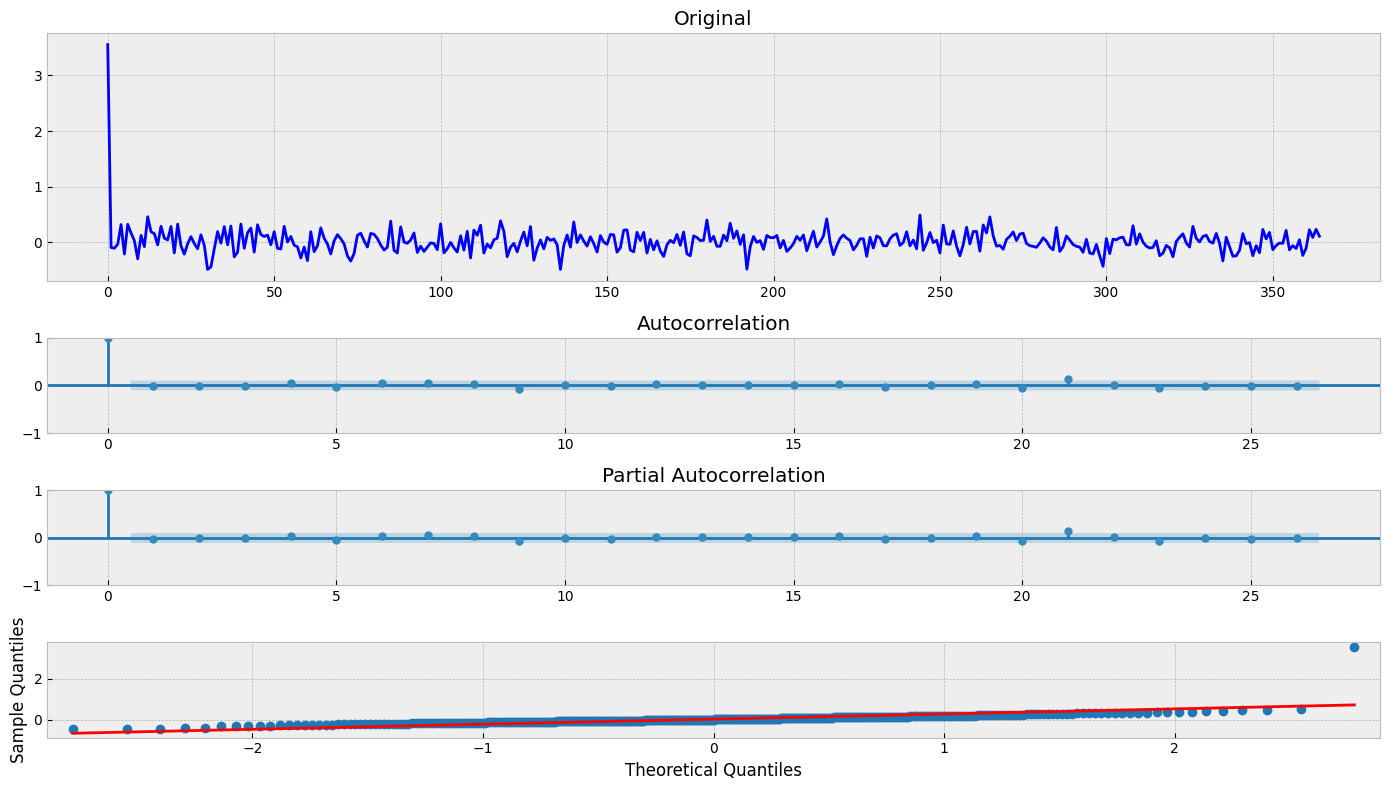

In [12]:
# Визуализация остатков новой модели
tsplot(mdl.resid)

In [13]:
order

(1, 1, 1)

In [14]:
# Применение модели GARCH к новой временной серии
p_ = order[1]
o_ = order[1]
q_ = order[1]

# Использование распределения Стьюдента для улучшения подгонки
am = arch_model(new_series*100, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     44,   Neg. LLF: 1561.816823066004
Iteration:     10,   Func. Count:     79,   Neg. LLF: 1561.481591077731
Iteration:     15,   Func. Count:    114,   Neg. LLF: 1561.4707953473476
Iteration:     20,   Func. Count:    149,   Neg. LLF: 1561.3233576391294
Iteration:     25,   Func. Count:    184,   Neg. LLF: 1560.1955589659706
Iteration:     30,   Func. Count:    220,   Neg. LLF: 1560.1756937345724
Iteration:     35,   Func. Count:    258,   Neg. LLF: 1979.1547909643864
Iteration:     40,   Func. Count:    298,   Neg. LLF: 1980.959419714072
Iteration:     45,   Func. Count:    336,   Neg. LLF: 1559.9082835482309
Iteration:     50,   Func. Count:    371,   Neg. LLF: 1559.9082421947796
Iteration:     55,   Func. Count:    406,   Neg. LLF: 1559.90815694708
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1559.908156684029
            Iterations: 56
            Function evaluations: 414
            Gradient evaluati

In [15]:
# Прогнозирование на основе модели GARCH
forecast = res.forecast(horizon=100)

In [16]:
new_series.shape

(365,)

In [17]:
new_series[-5:]

array([3.61091791, 3.95124372, 3.87120101, 4.00733319, 3.91202301])

In [18]:
forecast

In [19]:
forecast.residual_variance.iloc[-1]

,364
h.001,280.905095
h.002,302.735551
h.003,304.918790
h.004,305.137133
h.005,305.158970
...,...
h.096,305.161396
h.097,305.161396
h.098,305.161396
h.099,305.161396


[280.90509522 302.73555067 304.91878994 305.13713324 305.15896951
 305.16115333 305.16137173 305.16139358 305.16139576 305.16139598
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.161396   305.161396   305.161396
 305.161396   305.161396   305.16139

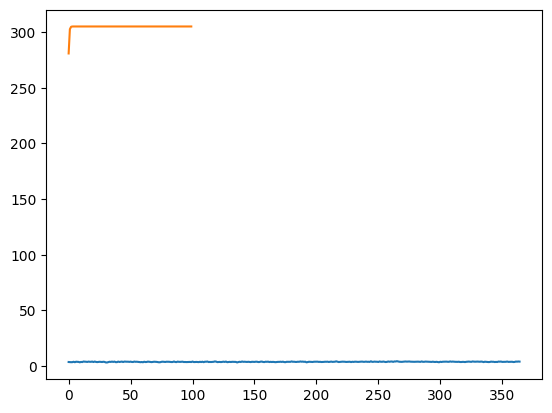

In [20]:
# Визуализация прогнозов и остатков
plt.plot(new_series)
print(forecast.residual_variance.iloc[-1].values)
plt.plot([0]*100 + forecast.residual_variance.iloc[-1].values)

Попробуем предсказать на основе дополнительных признаков:

In [22]:
# Загрузка данных
series = pd.read_csv("daily-total-female-births-in-cal.csv")

In [23]:
series

,Date,Count
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [24]:
# Создание дополнительных признаков на основе временного ряда
s = pd.DataFrame(series['Count'])
s.columns = ['curr_value']

window = 10
for i in range(1, window + 1):
    s[f'prev_val_{i}'] = s['curr_value'].shift(i)

s.dropna(inplace=True)
s.head(5)

,curr_value,prev_val_1,prev_val_2,prev_val_3,prev_val_4,prev_val_5,prev_val_6,prev_val_7,prev_val_8,prev_val_9,prev_val_10
10,38,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0,32.0,35.0
11,33,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0,32.0
12,55,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0
13,47,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0
14,45,47.0,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0


In [25]:
# Подготовка данных для обучения и тестирования модели
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # Индекс начала тестовой выборки
    test_index = int(len(data)*(1-test_size))

    # Добавление лагов исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.Count.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Date"], axis=1)

    # Разделение данных на обучающую и тестовую выборки
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]

    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

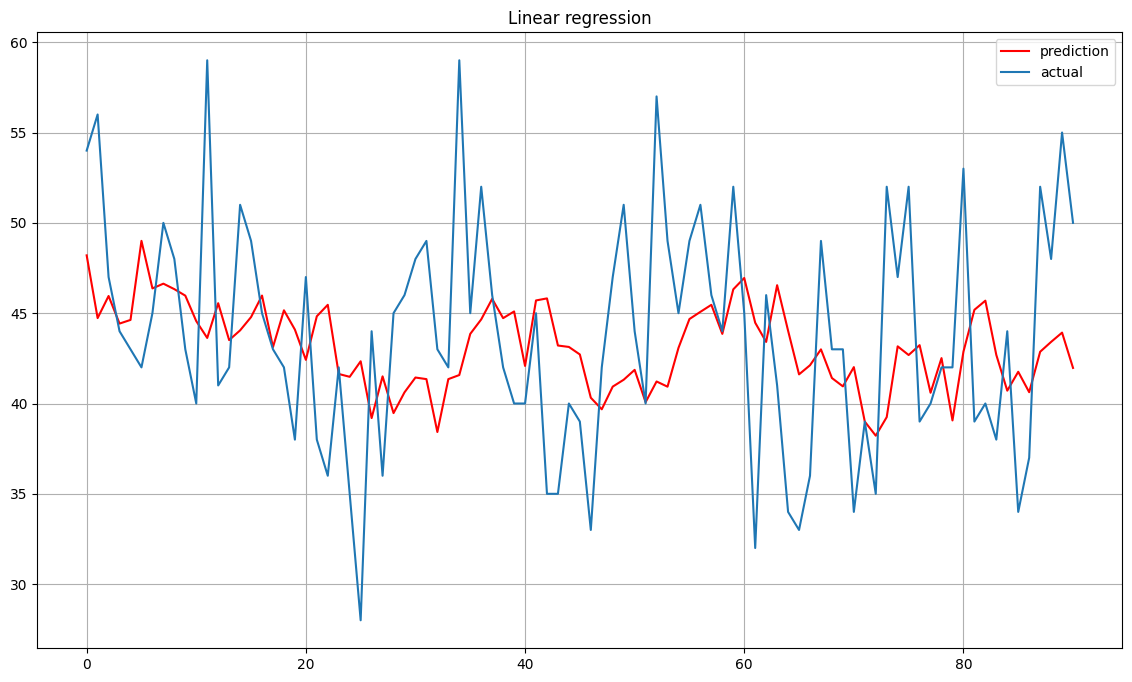

In [27]:
# Обучение модели линейной регрессии
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

# Визуализация прогнозов и фактических значений
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

# Вывод
В локальной среде перестали строиться графики с какого-то момента, пришлось переехать в гугл колаб, в котором всё хорошо оказалось... Гадаю, в памяти это проблема, или другая какая-то